In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
)
import insightlab as il

In [7]:
# Initialise InsightLab
il.section("Predictive Modelling: Campaign Response");

# Set domain + verbosity using the *new* signature
il.initialize(
    verbosity="stakeholder",   # or "technical" or "silent"
    domain="marketing",        # or None/"product"/whatever you use
    style=True,                # inject InsightLab CSS
    reset_trace=True           # start with a clean trace
)

- The Superstore file I’m using is a demo version of what, in a real company, would be a customer-level feature table built in the warehouse (BigQuery, Snowflake, etc.)

In [8]:
il.section("Can we predict which customers are most likely to respond to a marketing campaign, so we can improve ROI without increasing the campaign budget?");


* **Data & context**
    - 2,212 customers after cleaning and filters.
    - 33 input features combining RFM, channel behaviour, and web activity.
    - Target variable: Response (1 = responded to previous campaign).
    - Class imbalance: only 333 responders (~15%), so most customers do not respond.

* **Best model (final choice)**
    - Final model: Random Forest classifier.
    - Performance on hold-out test set:
    - Accuracy = 0.864
    - Precision = 0.841
    - Recall = 0.864
    - F1 score = 0.836

Logistic Regression performs similarly, but Random Forest is selected as final model because it offers strong performance plus rich feature importance for marketing insights.

    - Business impact (fixed budget, 332 contacts)
    - Random targeting (50% of customers)
    - Contacts = 332
    - Conversions ≈ 50
    - Cost = €332
    - Revenue ≈ €1,000
    - ROI ≈ 201%
    - Model-based targeting (top 50% scores)
    - Contacts = 332
    - Conversions = 93
    - Cost = €332
    - Revenue ≈ €1,860
    - ROI ≈ 460%

* Incremental effect of using the model

- +43 additional conversions for the same budget.
- ≈ €860 extra revenue and +259 percentage points of ROI uplift.
  
* **Key recommendations:**
1. Run an A/B test: compare model-based targeting versus business-as-usual / random selection for similar campaigns.
2. Use the Random Forest probabilities as a score to prioritise who to contact first when budgets are tight.
3. Combine model scores with business rules (e.g. channel preference, recency, complainers) to build robust contact policies.

* **Risks & next steps:**

- Data & concept drift: customer behaviour, product mix and campaign strategy will evolve over time. This may change the relationship between features and Response, gradually reducing model performance. Monitoring key metrics (conversion rate, lift, F1) over time is recommended to detect drift.

- Retraining policy: as a good practice, the model should be retrained periodically (for example every 6–12 months) or whenever we observe a significant drop in performance or major changes in campaign strategy.

- Potential bias: before scaling up, we should check that the model is not systematically prioritising only one customer type (e.g. only heavy spenders) and ignoring other potentially valuable segments. Reviewing scores and conversion rates by RFM segment, household structure and preferred channel can highlight potential biases.

- Governance: for a real deployment, it is useful to define simple governance: who owns the model, which minimum data fields are required, which KPIs will be monitored, and how often the model will be reviewed and retrained.
Define a simple governance checklist:



In [9]:
# Adjust path to your dataset
df = pd.read_csv(r"C:\Users\bravo\Portafolio\Dataset\superstore_data.csv")

df.head()


,Id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain
0,1826,1970,Graduation,Divorced,84835.0,0,0,6/16/2014,0,189,...,111,189,218,1,4,4,6,1,1,0
1,1,1961,Graduation,Single,57091.0,0,0,6/15/2014,0,464,...,7,0,37,1,7,3,7,5,1,0
2,10476,1958,Graduation,Married,67267.0,0,1,5/13/2014,0,134,...,15,2,30,1,3,2,5,2,0,0
3,1386,1967,Graduation,Together,32474.0,1,1,11/5/2014,0,10,...,0,0,0,1,1,0,2,7,0,0
4,5371,1989,Graduation,Single,21474.0,1,0,8/4/2014,0,6,...,11,0,34,2,3,1,2,7,1,0


In [10]:
# Date features (reproducible + aligned with Pattern Analysis)

# Robust conversion (won't crash if there are bad strings)
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"], errors="coerce")

# check invalid dates
n_bad = df["Dt_Customer"].isna().sum()
if n_bad > 0:
    print(f"[Warn] {n_bad} rows have invalid Dt_Customer (NaT).")

# Use an internal reference date so results don't change day-to-day
#    (common choice: latest join date in the dataset)
REF_DATE = df["Dt_Customer"].max()

# Join timing components (pattern-friendly naming)
df["Join_Year"] = df["Dt_Customer"].dt.year
df["Join_Month"] = df["Dt_Customer"].dt.month
df["Join_Weekday"] = df["Dt_Customer"].dt.day_name()          # optional but useful
df["Join_Cohort"] = df["Dt_Customer"].dt.to_period("M").astype(str)  # 'YYYY-MM'

# Tenure (lifecycle) — consistent and stable
df["Customer_Tenure_Days"] = (REF_DATE - df["Dt_Customer"]).dt.days

print("✓ Date conversion + lifecycle features completed!")
print(f"Dt_Customer dtype: {df['Dt_Customer'].dtype}")
print(f"Date range: {df['Dt_Customer'].min()} to {df['Dt_Customer'].max()} (REF_DATE={REF_DATE})")


✓ Date conversion + lifecycle features completed!
Dt_Customer dtype: datetime64[ns]
Date range: 2012-01-08 00:00:00 to 2014-12-06 00:00:00 (REF_DATE=2014-12-06 00:00:00)


In [11]:
# Variable types (using advanced detection from prep.detect_types)
il.story_variable_types(df);

In [12]:
# Missing values narrative
il.story_missing(df);

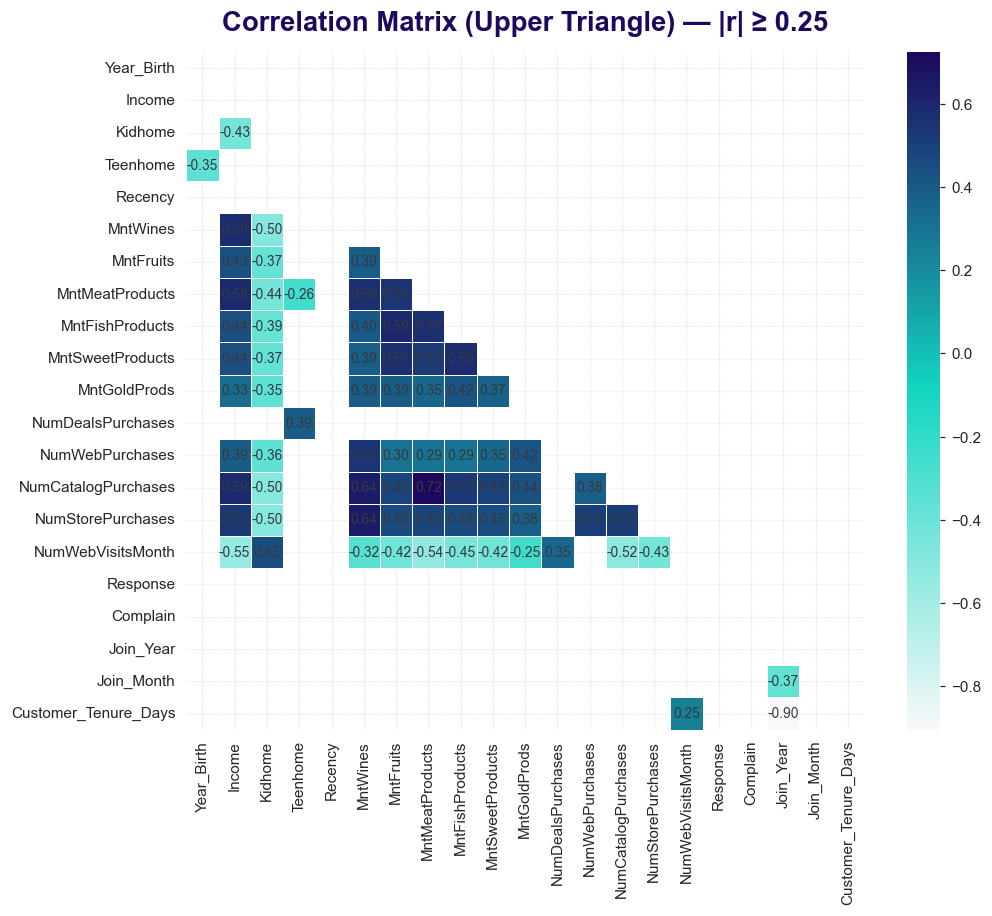

In [13]:
# Correlations (numeric only) — quick signal check (not causality)

il.section("Correlations (numeric only)")

df_corr = df.copy()
for c in ["ID", "Id"]:
    if c in df_corr.columns:
        df_corr = df_corr.drop(columns=[c])

_ = il.plot_correlation(df_corr, threshold=0.25, report=True)



In [14]:
# Correlations (numeric only)
il.section("Top numeric correlations with Response (Pearson)")

df_num = df.select_dtypes(include=[np.number]).copy()
for c in ["ID", "Id"]:
    if c in df_num.columns:
        df_num.drop(columns=[c], inplace=True)

if "Response" in df_num.columns:
    corr_resp = df_num.corr()["Response"].drop("Response")

    top = (
        corr_resp.reindex(corr_resp.abs().sort_values(ascending=False).index)
        .head(8)
        .reset_index()
        .rename(columns={"index": "Feature", "Response": "Pearson_r_with_Response"})
    )

    top["Pearson_r_with_Response"] = top["Pearson_r_with_Response"].round(3)

    # InsightLab-compatible output (no depende de show_dataframe)
    html = top.to_html(index=False)
    il.show_html(html)
else:
    il.box("warn", "Missing target", "Column 'Response' not found in numeric data.")

Feature,Pearson_r_with_Response
MntWines,0.247
MntMeatProducts,0.236
NumCatalogPurchases,0.221
Recency,-0.198
Customer_Tenure_Days,0.174
Join_Year,-0.171
Teenhome,-0.154
NumWebPurchases,0.149


In [15]:
# Response by Marital Status — distribution within each status

il.section("Response by Marital Status (distribution)")

df_tmp = df.copy()
df_tmp["Marital_Status"] = df_tmp["Marital_Status"].fillna("Unknown").astype(str).str.strip()
df_tmp["Response"] = df_tmp["Response"].astype(int)

# (Optional but recommended) Collapse rare categories to avoid noisy conclusions
MIN_N = 30
counts = df_tmp["Marital_Status"].value_counts()
rare = counts[counts < MIN_N].index
df_tmp["Marital_Status_Clean"] = df_tmp["Marital_Status"].where(~df_tmp["Marital_Status"].isin(rare), "Other")

# Detail by status + response (counts + % within status)
marital_resp_detail = (
    df_tmp
    .groupby(["Marital_Status_Clean", "Response"])
    .size()
    .reset_index(name="n")
)

marital_resp_detail["pct_within_status"] = (
    marital_resp_detail
    .groupby("Marital_Status_Clean")["n"]
    .transform(lambda s: s / s.sum() * 100)
)

response_map = {0: "No response", 1: "Yes response"}
marital_resp_detail["Response_Label"] = marital_resp_detail["Response"].map(response_map)


In [16]:
# Response rate by status — the actionable comparison

marital_summary = (
    df_tmp
    .groupby("Marital_Status_Clean")
    .agg(
        n_customers=("Response", "size"),
        responders=("Response", "sum"),
    )
    .reset_index()
)

marital_summary["response_rate_pct"] = (
    marital_summary["responders"] / marital_summary["n_customers"] * 100
)

marital_summary = marital_summary.sort_values(
    ["response_rate_pct", "n_customers"],
    ascending=[False, False]
)

# Render table inside InsightLab report (no il.show_dataframe needed)
table_html = marital_summary.assign(
    response_rate_pct=marital_summary["response_rate_pct"].round(2)
).to_html(index=False)

il.show_html(f"<h3>Response rate by Marital Status</h3>{table_html}")


Marital_Status_Clean,n_customers,responders,response_rate_pct
Other,7,3,42.86
Widow,77,19,24.68
Single,480,106,22.08
Divorced,232,48,20.69
Married,864,98,11.34
Together,580,60,10.34


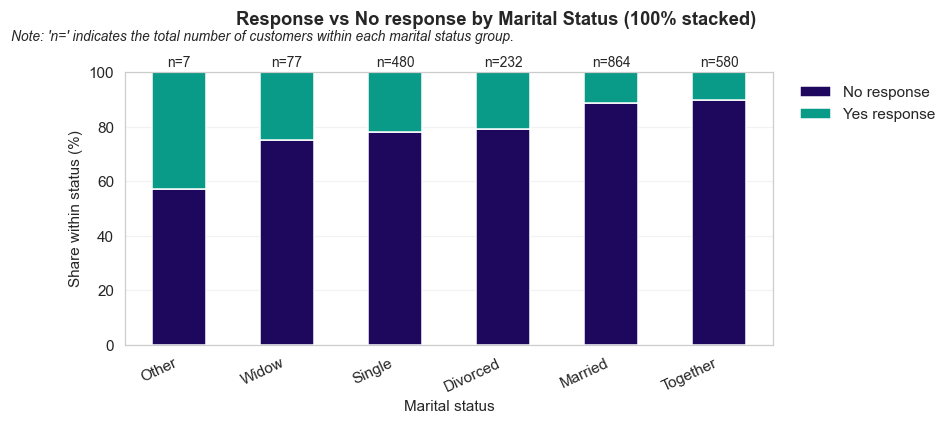

In [17]:
# Stacked bar: share within marital status (Response=0/1)

pivot = (
    marital_resp_detail
    .pivot(index="Marital_Status_Clean", columns="Response_Label", values="pct_within_status")
    .fillna(0)
)

# Ensure both columns exist
for col in ["No response", "Yes response"]:
    if col not in pivot.columns:
        pivot[col] = 0.0

# Reorder columns so "Yes response" is on top
pivot = pivot[["No response", "Yes response"]]

# Align order with summary (safe)
order = marital_summary["Marital_Status_Clean"].tolist()
pivot = pivot.reindex(order).fillna(0)

# --- Plot (explicit fig/ax for better layout control)
fig, ax = plt.subplots(figsize=(9, 4))

pivot.plot(kind="bar", stacked=True, ax=ax)

ax.set_ylabel("Share within status (%)")
ax.set_xlabel("Marital status")
ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha="right")

# Legend outside (RIGHT)
ax.legend(
    title="",
    loc="upper left",
    bbox_to_anchor=(1.02, 1),
    frameon=False
)

# Title + note at FIGURE level (prevents overlap with n labels)
fig.suptitle("Response vs No response by Marital Status (100% stacked)", y=0.98, fontsize=12, fontweight="bold")
fig.text(
    0.01, 0.92,
    "Note: 'n=' indicates the total number of customers within each marital status group.",
    ha="left", va="center", fontsize=9, style="italic"
)

# Add sample size labels ABOVE the bars
n_map = dict(zip(marital_summary["Marital_Status_Clean"], marital_summary["n_customers"]))
for i, status in enumerate(order):
    n = n_map.get(status, 0)
    ax.text(
        i, 1.01, f"n={n}",
        transform=ax.get_xaxis_transform(),
        ha="center", va="bottom", fontsize=9,
        clip_on=False
    )

ax.set_ylim(0, 100)

# Layout: space for legend (right) + title/note (top) + rotated x labels (bottom)
fig.subplots_adjust(right=0.78, top=0.84, bottom=0.22)

plt.show()


In [18]:
il.box(
    "info",
    "How to read this chart",
    "Each bar sums to 100% within a marital status group. The 'Yes response' segment shows the response rate within that group. "
    "Always interpret differences alongside sample sizes (n), especially for smaller categories."
);


In [19]:
# Response rate by Education (volume + rate + composition)
df_tmp = df.copy()

# Clean labels (stakeholder-friendly + robust)
df_tmp["Education"] = (
    df_tmp["Education"]
    .fillna("Unknown")
    .astype(str)
    .str.strip()
)

# Ensure target is numeric 0/1
df_tmp["Response"] = pd.to_numeric(df_tmp["Response"], errors="coerce").fillna(0).astype(int)

# Summary table
education_summary = (
    df_tmp
    .groupby("Education")["Response"]
    .agg(
        n_customers="size",      # robust total volume (works even if Response had NaNs)
        n_responders="sum",      # how many responders
        response_rate="mean",    # response rate (0..1)
    )
    .reset_index()
)

# Percent fields
education_summary["response_rate_pct"] = education_summary["response_rate"] * 100

education_summary["share_customers_pct"] = (
    education_summary["n_customers"] / education_summary["n_customers"].sum() * 100
)

total_responders = education_summary["n_responders"].sum()
education_summary["share_responders_pct"] = np.where(
    total_responders > 0,
    education_summary["n_responders"] / total_responders * 100,
    0.0
)

# Optional: stakeholder-friendly ordering + rounding
education_summary = education_summary.sort_values(
    ["response_rate_pct", "n_customers"],
    ascending=[False, False],
)

education_summary["response_rate_pct"] = education_summary["response_rate_pct"].round(2)
education_summary["share_customers_pct"] = education_summary["share_customers_pct"].round(1)
education_summary["share_responders_pct"] = education_summary["share_responders_pct"].round(1)

education_summary







,Education,n_customers,n_responders,response_rate,response_rate_pct,share_customers_pct,share_responders_pct
4,PhD,486,101,0.207819,20.78,21.7,30.2
3,Master,370,57,0.154054,15.41,16.5,17.1
2,Graduation,1127,152,0.134871,13.49,50.3,45.5
0,2n Cycle,203,22,0.108374,10.84,9.1,6.6
1,Basic,54,2,0.037037,3.70,2.4,0.6


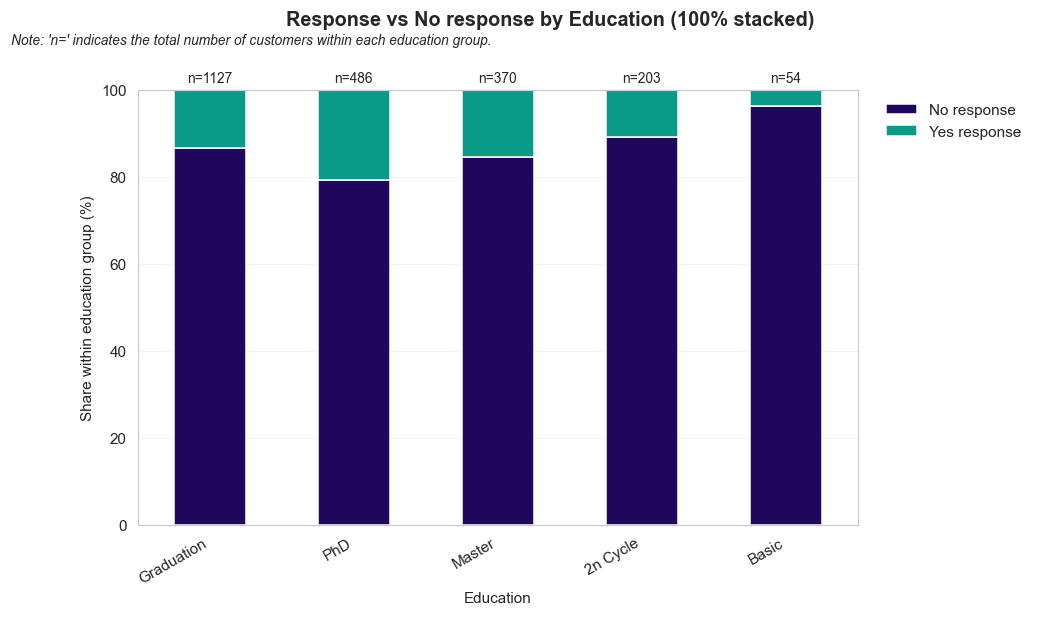

In [20]:
# Education — 100% stacked bar (Response within each education group)


df_tmp = df.copy()
df_tmp["Education"] = df_tmp["Education"].fillna("Unknown").astype(str).str.strip()
df_tmp["Response"] = pd.to_numeric(df_tmp["Response"], errors="coerce").fillna(0).astype(int)

# Detail table
education_resp_detail = (
    df_tmp
    .groupby(["Education", "Response"])
    .size()
    .reset_index(name="n")
)

education_resp_detail["pct_within_education"] = (
    education_resp_detail
    .groupby("Education")["n"]
    .transform(lambda s: s / s.sum() * 100)
)

# Counts
education_counts = (
    df_tmp
    .groupby("Education")
    .size()
    .reset_index(name="n_customers")
)

response_map = {0: "No response", 1: "Yes response"}
education_resp_detail["Response_Label"] = education_resp_detail["Response"].map(response_map)

# Pivot for stacked plot
pivot = (
    education_resp_detail
    .pivot(index="Education", columns="Response_Label", values="pct_within_education")
    .fillna(0)
)

# Ensure both columns exist
for col in ["No response", "Yes response"]:
    if col not in pivot.columns:
        pivot[col] = 0.0

pivot = pivot[["No response", "Yes response"]]

# Order categories by volume (nice UX)
order = (
    education_counts.sort_values("n_customers", ascending=False)["Education"]
    .tolist()
)
pivot = pivot.reindex(order).fillna(0)

# Plot
# --- Plot (Education, 100% stacked)
fig, ax = plt.subplots(figsize=(10, 6))

pivot.plot(kind="bar", stacked=True, ax=ax)

ax.set_ylabel("Share within education group (%)")
ax.set_xlabel("Education")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")

# Legend outside (right)
ax.legend(title="", loc="upper left", bbox_to_anchor=(1.02, 1), frameon=False)

# Put title and note at FIGURE level (prevents overlap with n labels)
fig.suptitle("Response vs No response by Education (100% stacked)", y=0.98, fontsize=13, fontweight="bold")
fig.text(
    0.01, 0.935,
    "Note: 'n=' indicates the total number of customers within each education group.",
    ha="left", va="center", fontsize=9, style="italic"
)

# Add n labels above each bar (stable placement)
count_map = dict(zip(education_counts["Education"], education_counts["n_customers"]))
for i, edu in enumerate(order):
    n = count_map.get(edu, 0)
    ax.text(
        i, 1.01, f"n={n}",
        transform=ax.get_xaxis_transform(),  # x in data coords, y in axes coords
        ha="center", va="bottom", fontsize=9,
        clip_on=False
    )

ax.set_ylim(0, 100)

# Reserve space: right for legend, top for suptitle+note, bottom for rotated x labels
fig.subplots_adjust(right=0.78, top=0.86, bottom=0.20)

plt.show()


In [21]:
print("→ Domain-based cleaning and feature engineering...")

df_tmp = df.copy()

# --- Reproducible reference year (align with pattern analysis)
if "Dt_Customer" in df_tmp.columns:
    df_tmp["Dt_Customer"] = pd.to_datetime(df_tmp["Dt_Customer"], errors="coerce")
    REF_YEAR = int(df_tmp["Dt_Customer"].dt.year.max())
else:
    REF_YEAR = pd.Timestamp.today().year

# --- Domain guards (robust to NaNs)
df_clean = df_tmp.loc[
    (df_tmp["Income"].notna()) &
    (df_tmp["Income"] > 0) &
    (df_tmp["Income"] < 200000) &
    (df_tmp["Year_Birth"].notna()) &
    (df_tmp["Year_Birth"] > 1920)
].copy()

# --- Derived features
df_clean["Age"] = REF_YEAR - df_clean["Year_Birth"]

spending_cols = [
    "MntWines", "MntFruits", "MntMeatProducts",
    "MntFishProducts", "MntSweetProducts", "MntGoldProds",
]
spending_cols = [c for c in spending_cols if c in df_clean.columns]

if spending_cols:
    df_clean["Total_Spending"] = df_clean[spending_cols].sum(axis=1)
else:
    df_clean["Total_Spending"] = 0.0

purchase_cols = [
    "NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases",
]
purchase_cols = [c for c in purchase_cols if c in df_clean.columns]

if purchase_cols:
    df_clean["Total_Purchases"] = df_clean[purchase_cols].sum(axis=1)
else:
    df_clean["Total_Purchases"] = 0

# Optional but valuable (marketing): online share / intensity
if "NumWebPurchases" in df_clean.columns:
    df_clean["Online_Share"] = np.where(
        df_clean["Total_Purchases"] > 0,
        df_clean["NumWebPurchases"] / df_clean["Total_Purchases"],
        0.0
    )

print(f"   Rows after filters: {len(df_clean):,}")
print(f"   REF_YEAR used for Age: {REF_YEAR}")
print(f"   Spending columns used ({len(spending_cols)}): {spending_cols}")
print(f"   Purchase columns used ({len(purchase_cols)}): {purchase_cols}")



→ Domain-based cleaning and feature engineering...
   Rows after filters: 2,212
   REF_YEAR used for Age: 2014
   Spending columns used (6): ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
   Purchase columns used (3): ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']


* **Key derived features**

- RFM-style aggregates:

    - Total_Spending = total amount spent across all product categories.
    - Total_Purchases = total number of purchases across web, catalogue and store.
- Customer lifetime features:

    Age, Customer_Year, Customer_Month, Days_Since_Signup derived from Year_Birth and Dt_Customer.

In [22]:
from insightlab import Cleaner, get_numeric_cols

print("\n→ Running InsightLab Cleaner pipeline...")

# --- Defensive lists (avoid KeyErrors if schema changes)
spending_cols_present = [c for c in spending_cols if c in df_clean.columns]

# Robust ID / leakage exclusions
id_like = [c for c in ["Id", "ID", "CustomerID"] if c in df_clean.columns]
target_like = [c for c in ["Response"] if c in df_clean.columns]
binary_like = [c for c in ["Complain"] if c in df_clean.columns]

# Campaign-history columns often exist in this dataset; keep them numeric but usually exclude from scaling for interpretability
accepted_cols = [c for c in df_clean.columns if c.startswith("AcceptedCmp")]
exclude_from_scaling = target_like + binary_like + id_like + accepted_cols

# Decide which columns to scale (numeric but excluding IDs/targets/binaries)
numeric_cols = get_numeric_cols(df_clean)
cols_to_scale = [c for c in numeric_cols if c not in exclude_from_scaling]

print(f"   Numeric columns detected: {len(numeric_cols)}")
print(f"   Columns excluded from scaling: {exclude_from_scaling}")
print(f"   Columns to scale: {len(cols_to_scale)}")

# Build cleaning pipeline
c = Cleaner(df_clean)


cat_cols_to_onehot = df_clean.select_dtypes(include=["object", "category"]).columns.tolist()

# Exclude IDs/target from one-hot (and anything else you consider identifier-like)
cat_exclude = set(id_like + target_like)
cat_cols_to_onehot = [c for c in cat_cols_to_onehot if c not in cat_exclude]

print(f"   Categorical columns to one-hot: {len(cat_cols_to_onehot)}")
if len(cat_cols_to_onehot) > 0:
    print(f"   → {cat_cols_to_onehot}")

(
    c
    .duplicates()  # remove duplicate rows
    .missing(
        numeric="median",
        categorical="mode",
        datetime=None
    )
    .log_transform(
        cols=spending_cols_present,
        add_constant=1.0
    )
    .scale(
        method="standard",
        cols=cols_to_scale
    )
    .onehot(
        cols=cat_cols_to_onehot
    )
)

prep_result = c.to_result()

df_encoded = prep_result.df.copy()
prep_metadata = prep_result.metadata
prep_quality = prep_result.quality

print(f"\n✓ Prep complete: {df_encoded.shape[0]:,} rows, {df_encoded.shape[1]:,} columns")
print("   Logged steps:", list(prep_metadata.keys()))

# Optional: quick quality read-out (only if available)
if isinstance(prep_quality, dict) and len(prep_quality) > 0:
    print("\n→ Prep quality snapshot:")
    for k in ["duplicates_removed", "missing_before", "missing_after", "outliers_flagged"]:
        if k in prep_quality:
            print(f"   {k}: {prep_quality[k]}")




→ Running InsightLab Cleaner pipeline...
   Numeric columns detected: 26
   Columns excluded from scaling: ['Response', 'Complain', 'Id']
   Columns to scale: 23
   Categorical columns to one-hot: 4
   → ['Education', 'Marital_Status', 'Join_Weekday', 'Join_Cohort']

✓ Prep complete: 2,212 rows, 79 columns
   Logged steps: ['duplicates', 'missing', 'log_transform', 'scale', 'onehot']

→ Prep quality snapshot:


Applied basic domain rules and filters (e.g. valid customers, consistent spending information).
Removed ID-like fields from modelling (Id) so that the model focuses on behaviour, not identifiers.
Kept 2,212 customers after filtering.

- **Handling skew and outliers:** Applied log transformations to right-skewed spending variables (MntWines, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts, MntGoldProds).

This reduces the impact of extreme big spenders and helps models that assume more symmetric distributions.

- **Scaling numeric variables:** Used standard scaling on 22 numeric variables, excluding the target and IDs (Response, Complain, Id).

Scaled features include demographics, RFM metrics and channel behaviour (e.g. Total_Spending, Total_Purchases, NumWebPurchases, NumStorePurchases, NumWebVisitsMonth).

- **Encoding categorical variables:** Applied one-hot encoding to Education and Marital_Status so the model can use them without imposing an artificial numeric order.

In [23]:
# ------------------------------------------------------------------
# Story layers — Preparation rationale (portfolio-ready)
# ------------------------------------------------------------------

n_customers = df_encoded.shape[0]
n_features = df_encoded.shape[1]

# Optional quality metrics (safe fallbacks)
dups_removed = prep_quality.get("duplicates_removed", "n/a") if isinstance(prep_quality, dict) else "n/a"

# Missingness (post-prep)
missing_rate_pct = (df_encoded.isna().mean().mean() * 100)

# One-hot expansion (simple estimate)
n_onehot_inputs = len(cat_cols_to_onehot) if "cat_cols_to_onehot" in globals() else 0

il.layers(
    descriptive=(
        f"After cleaning and preparation, the modelling table contains {n_customers:,} customers "
        f"and {n_features:,} feature columns (post-encoding)."
        + (f" Duplicate handling removed {dups_removed} rows." if dups_removed != "n/a" else "")
        + f" Remaining missingness is ~{missing_rate_pct:.2f}% across the table."
    ),
    statistical=(
        "To improve model stability, spending variables were log-transformed to reduce skew, "
        f"and {len(cols_to_scale):,} continuous features were standardised. "
        + (
            f"Categorical demographics ({', '.join(cat_cols_to_onehot)}) were one-hot encoded, "
            if n_onehot_inputs > 0 else
            "Categorical demographics were one-hot encoded, "
        )
        + "which is appropriate for both linear (logistic regression) and non-linear (tree-based) models."
    ),
    behavioural=(
        "The engineered predictors map to CRM behaviour (customer value, purchase frequency, tenure, and channel usage), "
        "making model patterns easier to interpret in business terms rather than raw transactional fields."
    ),
    strategic=(
        "This preprocessing reduces the risk that model performance is driven by data artefacts (duplicates, missingness, skew) "
        "and increases confidence that uplift is linked to meaningful customer signals."
    ),
    operational=(
        "Because the steps are defined as a single pipeline, the same transformations can be re-applied to future campaign extracts "
        "to refresh the training set and score new customers consistently."
    ),
);

In [24]:
print("\n→ Final Data Check:")

n_rows = df_encoded.shape[0]
n_cols = df_encoded.shape[1]

print(f"   Total rows: {n_rows:,}")
print(f"   Total columns: {n_cols:,}")

if "Response" not in df_encoded.columns:
    print("   ❌ ERROR: Target column 'Response' not found in df_encoded.")
else:
    # Ensure numeric 0/1
    y = pd.to_numeric(df_encoded["Response"], errors="coerce").fillna(0).astype(int)

    n_pos = int((y == 1).sum())
    n_neg = int((y == 0).sum())

    print(f"   Response = 0: {n_neg:,}")
    print(f"   Response = 1: {n_pos:,}")

    if n_pos > 0:
        prevalence = n_pos / (n_pos + n_neg) * 100
        imbalance_ratio = n_neg / n_pos

        print(f"   Positive rate: {prevalence:.1f}%")
        print(f"   Imbalance ratio: {imbalance_ratio:.1f}:1 (0:1)")

        # Simple modelling readiness check
        if n_pos < 50:
            print("   ⚠ Warning: very few positive cases — metrics will be unstable and CV is recommended.")
        else:
            print("   ✓ Data is ready for modelling!")
    else:
        print("   ❌ ERROR: No positive Response cases — modelling cannot proceed.")



→ Final Data Check:
   Total rows: 2,212
   Total columns: 79
   Response = 0: 1,879
   Response = 1: 333
   Positive rate: 15.1%
   Imbalance ratio: 5.6:1 (0:1)
   ✓ Data is ready for modelling!


The dataset is now analysis-ready: clear structure, low missingness, business-relevant features and standardised scales. Any conclusions about campaign performance or ROI uplift are built on this solid foundation. 

##### **Modelling dataset**

* **Features (X)**
    - 2,212 customers after cleaning and domain-based filters.
    - 33 predictor variables, combining:
    - RFM-style metrics such as total spending and total purchases.
    - Channel behaviour (web, catalogue, store purchases and web visits).
    - Customer tenure and basic demographics.
    - ID-like fields (e.g. Id) are excluded from modelling so the model focuses on behaviour rather than technical identifiers.

* **Target (y)**
    - Binary target: Response (1 = customer responded to a previous campaign, 0 = did not respond).
    - Class distribution:
    - Non-responders (0): 1,879 customers (~85%)
    - Responders (1): 333 customers (~15%)

##### **Why class imbalance matters**
* Naive baseline without a model
    - If we contact everyone, the historical average response rate is ~15%.
    - If we build a trivial classifier that always predicts “no response”, it would still achieve ~85% accuracy, simply because most customers do not respond.
    - This shows that accuracy alone is misleading in an imbalanced setting.

* Implications for model evaluation
    - We focus on **precision, recall and F1 score** rather than accuracy alone:
        - **Precision:** how many of the customers we target as “likely responders” actually respond (efficiency of marketing spend).
        - **Recall:** how many of all potential responders we manage to capture (opportunity captured).
        - **F1:** single summary that balances both.

Responders are the minority, but they are the ones that matter for campaign ROI. A good model concentrates more responders on the top-scoring customers than we would with random or “contact everyone” strategies. This is why, in later sections, we compare model-based targeting vs random targeting using conversion rate and ROI rather than relying only on global accuracy.

In [25]:
# Separate features and target (leakage-safe)

# Target
y = pd.to_numeric(df_encoded["Response"], errors="coerce").fillna(0).astype(int)

# Columns to drop (robust + common leakage)
drop_cols = ["Response", "Complain", "Id", "ID", "Dt_Customer", "Z_CostContact", "Z_Revenue"]

# Optional: past-campaign acceptance flags (decide based on your narrative)
accepted_cols = [c for c in df_encoded.columns if c.startswith("AcceptedCmp")]
drop_cols += accepted_cols

X = df_encoded.drop(columns=drop_cols, errors="ignore")

print("\n→ Modelling Dataset:")
print(f"   Features (X): {X.shape}")
print(f"   Target (y):   {y.shape}")

dist_counts = y.value_counts().to_dict()
dist_pct = (y.value_counts(normalize=True) * 100).round(1).to_dict()
print(f"   Target distribution (counts): {dist_counts}")
print(f"   Target distribution (%):      {dist_pct}")


# Train/test split with stratification

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.35,
    stratify=y,
    random_state=42,
)

print("\n→ Train/Test Split:")
print(f"   X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"   X_test:  {X_test.shape},  y_test:  {y_test.shape}")
print(f"   Train positive rate: {y_train.mean()*100:.1f}% | Test positive rate: {y_test.mean()*100:.1f}%")



→ Modelling Dataset:
   Features (X): (2212, 75)
   Target (y):   (2212,)
   Target distribution (counts): {0: 1879, 1: 333}
   Target distribution (%):      {0: 84.9, 1: 15.1}

→ Train/Test Split:
   X_train: (1437, 75), y_train: (1437,)
   X_test:  (775, 75),  y_test:  (775,)
   Train positive rate: 15.0% | Test positive rate: 15.1%


In [26]:

# Train/Test split (your current approach)

RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=RANDOM_STATE,
)

print("\n→ Train/Test Split:")
print(f"   X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"   X_test:  {X_test.shape},  y_test:  {y_test.shape}")


# Calibration split (from training) — ONLY for threshold selection
#    (We keep training on full X_train, y_train to keep your workflow simple.)

_, X_cal, _, y_cal = train_test_split(
    X_train, y_train,
    test_size=0.25,           # 25% of training used for threshold selection
    stratify=y_train,
    random_state=RANDOM_STATE,
)

print("\n→ Calibration Split (for threshold selection only):")
print(f"   X_cal: {X_cal.shape}, y_cal: {y_cal.shape}")


# 3) Train models

from insightlab import (
    train_logistic_regression,
    train_random_forest,
)

il.section("Model Training and Comparison")

il.box(
    "info",
    "Training setup",
    "Two baseline models are trained for comparison: Logistic Regression (interpretable baseline) and Random Forest "
    "(non-linear model). Because Response is imbalanced, we use class-weighting when available and fix random_state "
    "for reproducibility."
)

print("\n→ Training models...\n")

# Logistic Regression
try:
    log_res = train_logistic_regression(
        X_train, y_train,
        max_iter=1000,
        C=1.0,
        class_weight="balanced",
        random_state=RANDOM_STATE,
    )
except TypeError:
    log_res = train_logistic_regression(
        X_train, y_train,
        max_iter=1000,
        C=1.0,
    )
log_model = log_res["model"]

# Random Forest
try:
    rf_res = train_random_forest(
        X_train, y_train,
        n_estimators=200,
        max_depth=10,
        class_weight="balanced_subsample",
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )
except TypeError:
    rf_res = train_random_forest(
        X_train, y_train,
        n_estimators=200,
        max_depth=10,
    )
rf_model = rf_res["model"]

print("✓ Models trained:")
print("   - Logistic Regression")
print("   - Random Forest")


# Choose threshold on CALIBRATION set (NOT test)

def pick_threshold_by_f1(y_true, y_proba, grid=None):
    """
    Choose probability threshold that maximises F1 for the responder class (1).
    IMPORTANT: use calibration/validation set, not the holdout test.
    """
    if grid is None:
        grid = np.linspace(0.05, 0.95, 19)

    y_true = np.asarray(y_true).astype(int)

    best_thr = 0.50
    best_f1 = -1.0

    for thr in grid:
        y_pred = (y_proba >= thr).astype(int)
        f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
        if f1 > best_f1:
            best_f1 = float(f1)
            best_thr = float(thr)

    return best_thr, best_f1

# Calibrate thresholds (per model)
log_cal_proba = log_model.predict_proba(X_cal)[:, 1]
log_thr, log_f1_cal = pick_threshold_by_f1(y_cal, log_cal_proba)

rf_cal_proba = rf_model.predict_proba(X_cal)[:, 1]
rf_thr, rf_f1_cal = pick_threshold_by_f1(y_cal, rf_cal_proba)

il.box(
    "neutral",
    "Threshold selection (Patch 3)",
    f"Thresholds are selected on a calibration split (not the holdout test) to avoid test leakage.<br>"
    f"<b>Logistic Regression</b>: thr={log_thr:.2f} (F1_cal={log_f1_cal:.3f})<br>"
    f"<b>Random Forest</b>: thr={rf_thr:.2f} (F1_cal={rf_f1_cal:.3f})"
)


#  Evaluate on HOLDOUT TEST using the fixed thresholds

def evaluate_on_test(name, model, X_test, y_test, thr):
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= thr).astype(int)

    metrics = {
        "accuracy": float(accuracy_score(y_test, y_pred)),
        "precision_pos": float(precision_score(y_test, y_pred, pos_label=1, zero_division=0)),
        "recall_pos": float(recall_score(y_test, y_pred, pos_label=1, zero_division=0)),
        "f1_pos": float(f1_score(y_test, y_pred, pos_label=1, zero_division=0)),
        "roc_auc": float(roc_auc_score(y_test, y_proba)),
        "pr_auc": float(average_precision_score(y_test, y_proba)),
        "threshold": float(thr),
    }

    return {
        "model": model,
        "y_pred": y_pred,
        "y_proba": y_proba,
        "metrics": metrics,
        "name": name,
    }

results = {}
results["Logistic Regression"] = evaluate_on_test(
    "Logistic Regression", log_model, X_test, y_test, log_thr
)
results["Random Forest"] = evaluate_on_test(
    "Random Forest", rf_model, X_test, y_test, rf_thr
)

il.section("Holdout Test Performance (Responder-focused)")

# Small readable summary
for mname, res in results.items():
    met = res["metrics"]
    il.box(
        "info",
        mname,
        f"<b>Threshold:</b> {met['threshold']:.2f}<br>"
        f"<b>Accuracy:</b> {met['accuracy']:.3f}<br>"
        f"<b>Precision (responders):</b> {met['precision_pos']:.3f}<br>"
        f"<b>Recall (responders):</b> {met['recall_pos']:.3f}<br>"
        f"<b>F1 (responders):</b> {met['f1_pos']:.3f}<br>"
        f"<b>ROC-AUC:</b> {met['roc_auc']:.3f} &nbsp; | &nbsp; <b>PR-AUC:</b> {met['pr_auc']:.3f}"
    )



→ Train/Test Split:
   X_train: (1548, 75), y_train: (1548,)
   X_test:  (664, 75),  y_test:  (664,)

→ Calibration Split (for threshold selection only):
   X_cal: (387, 75), y_cal: (387,)



→ Training models...

✓ Models trained:
   - Logistic Regression
   - Random Forest


In [27]:
from insightlab import (
    train_logistic_regression,
    train_random_forest,
)

il.section("Model Training and Comparison")

il.box(
    "info",
    "Training setup",
    "Two baseline models are trained for comparison: Logistic Regression (interpretable baseline) and Random Forest "
    "(non-linear model). Because Response is imbalanced, we use class-weighting when available and fix random_state "
    "for reproducibility."
)

print("\n→ Training models...\n")

RANDOM_STATE = 42


# Guard: ensure X is numeric (avoid 'could not convert string to float')

non_numeric_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
if non_numeric_cols:
    print(f"[Warn] Dropping non-numeric columns from X_train/X_test: {non_numeric_cols}")
    X_train = X_train.drop(columns=non_numeric_cols)
    X_test  = X_test.drop(columns=non_numeric_cols)


# Logistic Regression (baseline)

try:
    log_res = train_logistic_regression(
        X_train,
        y_train,
        max_iter=1000,
        C=1.0,
        class_weight="balanced",
        random_state=RANDOM_STATE,
    )
except TypeError:
    # Fallback for older InsightLab signatures (no extra kwargs supported)
    log_res = train_logistic_regression(
        X_train,
        y_train,
        max_iter=1000,
        C=1.0,
    )

log_model = log_res["model"]


# Random Forest (non-linear)

try:
    rf_res = train_random_forest(
        X_train,
        y_train,
        n_estimators=200,
        max_depth=10,
        class_weight="balanced_subsample",
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )
except TypeError:
    # Fallback for older InsightLab signatures
    rf_res = train_random_forest(
        X_train,
        y_train,
        n_estimators=200,
        max_depth=10,
    )

rf_model = rf_res["model"]

print("✓ Models trained:")
print("   - Logistic Regression")
print("   - Random Forest")



→ Training models...

✓ Models trained:
   - Logistic Regression
   - Random Forest


### **Models compared**
**Logistic Regression (baseline)**
- Linear model that estimates the probability of response as a logistic function of the inputs.
- Easy to interpret (coefficients with sign and magnitude), good as a baseline.

**Random Forest (final model)**

* Ensemble of many decision trees trained on different subsets of data and features.
* Captures non-linear relationships and interactions between variables (e.g. spending × recency × channel).
+ Provides feature importance, which is helpful later to understand which behaviours drive campaign response.


→ Evaluating models...



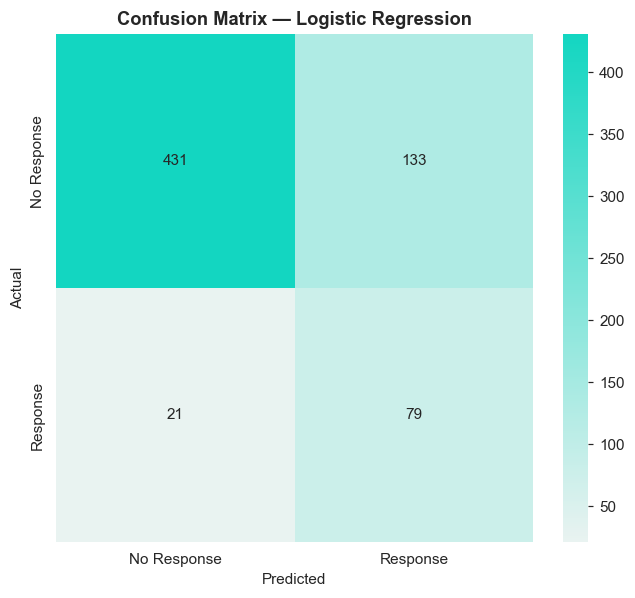

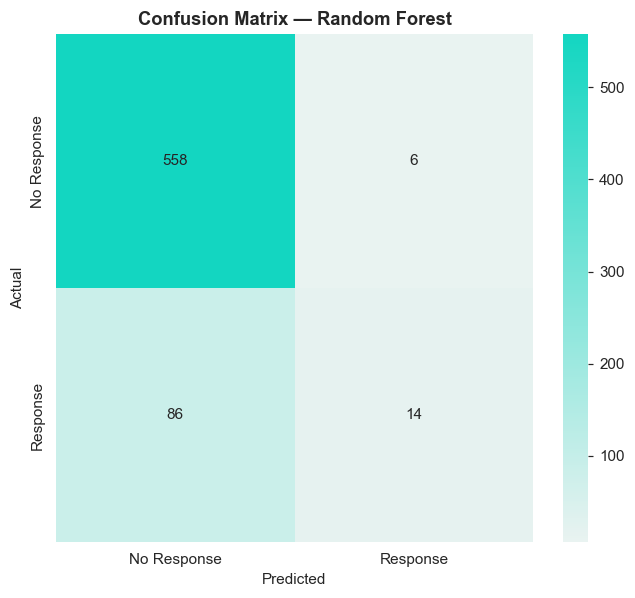

In [28]:
from insightlab import evaluate_classification

print("\n→ Evaluating models...\n")

# Predictions + probabilities
log_pred = log_model.predict(X_test)
log_proba = log_model.predict_proba(X_test)[:, 1]

rf_pred = rf_model.predict(X_test)
rf_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluate via InsightLab
log_eval = evaluate_classification(
    y_true=y_test,
    y_pred=log_pred,
    y_proba=log_proba,
    class_names=["No Response", "Response"],
    plot=True,
    model_name="Logistic Regression",  
)

rf_eval = evaluate_classification(
    y_true=y_test,
    y_pred=rf_pred,
    y_proba=rf_proba,
    class_names=["No Response", "Response"],
    plot=True,
    model_name="Random Forest",     
)

results = {
    "Logistic Regression": {
        **log_eval,
        "y_pred": log_pred,
        "y_proba": log_proba,
        "model": log_model,
    },
    "Random Forest": {
        **rf_eval,
        "y_pred": rf_pred,
        "y_proba": rf_proba,
        "model": rf_model,
    },
}



Model Comparison Summary:
              Model  Accuracy  Precision (Responders)  Recall (Responders)  F1 (Responders)  ROC-AUC  PR-AUC
Logistic Regression     0.768                   0.373                 0.79            0.506    0.861   0.512
      Random Forest     0.861                   0.700                 0.14            0.233    0.866   0.556


Model,Accuracy,Precision (Responders),Recall (Responders),F1 (Responders),ROC-AUC,PR-AUC
Logistic Regression,0.768,0.373,0.79,0.506,0.861,0.512
Random Forest,0.861,0.700,0.14,0.233,0.866,0.556


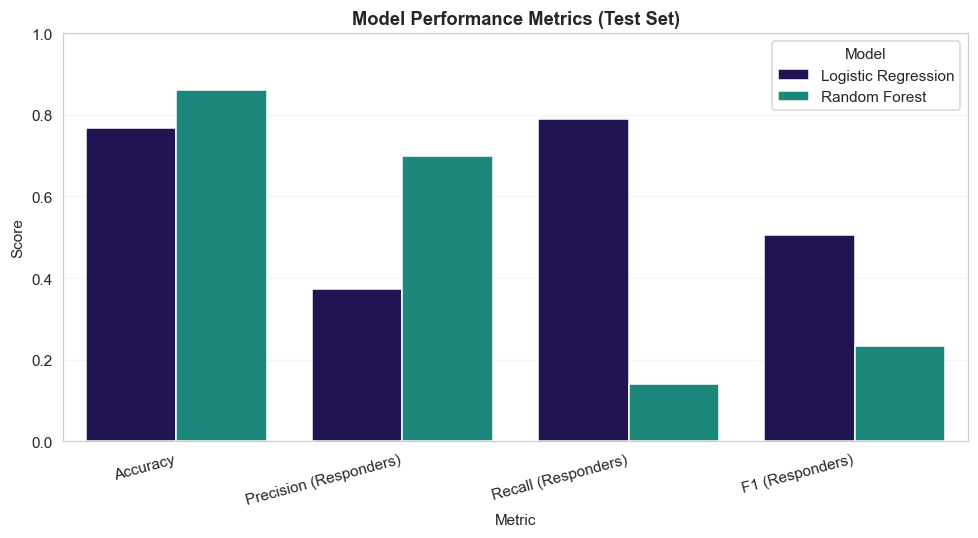

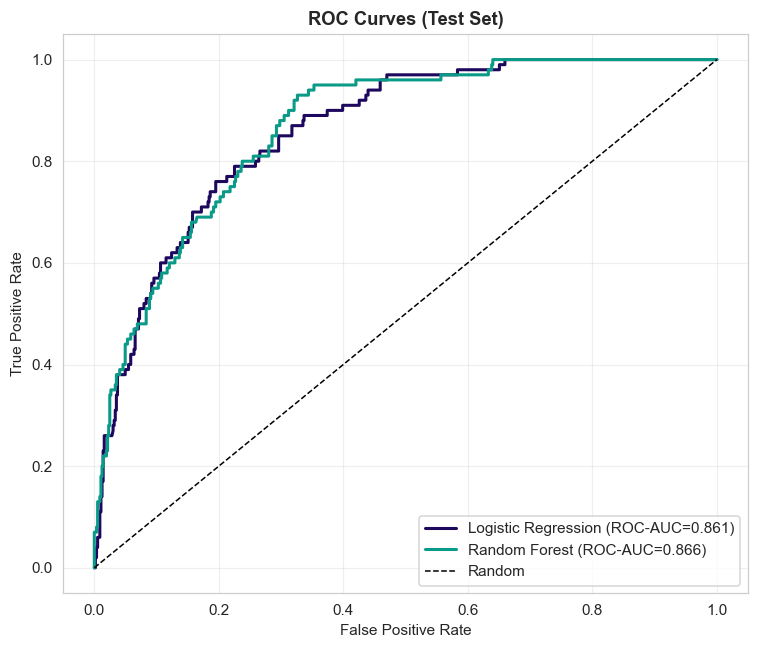

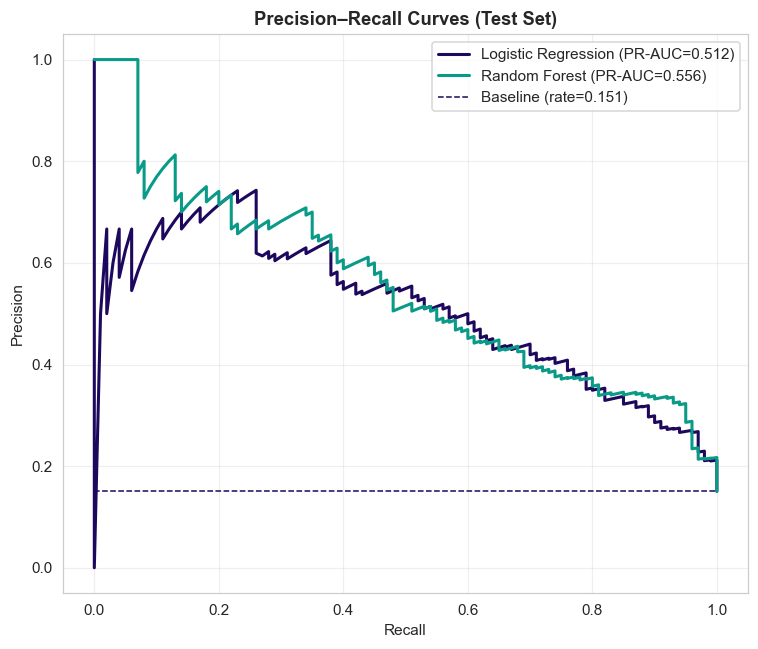

In [29]:
il.section("Model Performance Comparison")

# Ensure metrics are computed consistently (esp. positive class)

for name, res in results.items():
    y_pred = res.get("y_pred")
    y_proba = res.get("y_proba")

    # If you only stored y_proba but not y_pred, you can threshold at 0.5:
    if y_pred is None and y_proba is not None:
        y_pred = (y_proba >= 0.5).astype(int)
        res["y_pred"] = y_pred

    res.setdefault("metrics", {})

    if y_pred is not None:
        # Overall
        res["metrics"]["accuracy"] = float(accuracy_score(y_test, y_pred))

        # Positive-class focused (what matters for responders)
        res["metrics"]["precision_pos"] = float(precision_score(y_test, y_pred, pos_label=1, zero_division=0))
        res["metrics"]["recall_pos"] = float(recall_score(y_test, y_pred, pos_label=1, zero_division=0))
        res["metrics"]["f1_pos"] = float(f1_score(y_test, y_pred, pos_label=1, zero_division=0))

    if y_proba is not None:
        res["metrics"]["roc_auc"] = float(roc_auc_score(y_test, y_proba))
        res["metrics"]["pr_auc"] = float(average_precision_score(y_test, y_proba))


# Comparison table 
comparison_df = pd.DataFrame({
    "Model": list(results.keys()),
    "Accuracy": [results[m]["metrics"].get("accuracy", np.nan) for m in results],
    "Precision (Responders)": [results[m]["metrics"].get("precision_pos", np.nan) for m in results],
    "Recall (Responders)": [results[m]["metrics"].get("recall_pos", np.nan) for m in results],
    "F1 (Responders)": [results[m]["metrics"].get("f1_pos", np.nan) for m in results],
    "ROC-AUC": [results[m]["metrics"].get("roc_auc", np.nan) for m in results],
    "PR-AUC": [results[m]["metrics"].get("pr_auc", np.nan) for m in results],
}).round(3)

print("\nModel Comparison Summary:")
print(comparison_df.to_string(index=False))

# Optional: show in InsightLab report
il.show_html(comparison_df.to_html(index=False))


# Barplot (core classification metrics)

fig, ax = plt.subplots(figsize=(9, 5))

comparison_long = comparison_df.melt(
    id_vars="Model",
    value_vars=["Accuracy", "Precision (Responders)", "Recall (Responders)", "F1 (Responders)"],
    var_name="Metric",
    value_name="Score",
)

sns.barplot(
    data=comparison_long,
    x="Metric",
    y="Score",
    hue="Model",
    ax=ax,
)

ax.set_title("Model Performance Metrics (Test Set)")
ax.set_ylim(0, 1)
ax.grid(True, axis="y", alpha=0.2)
plt.xticks(rotation=15, ha="right")
plt.tight_layout()
plt.show()


# ROC curves

fig, ax = plt.subplots(figsize=(7, 6))

for name, res in results.items():
    y_proba = res.get("y_proba")
    if y_proba is None:
        continue

    auc = res["metrics"]["roc_auc"]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    ax.plot(fpr, tpr, linewidth=2, label=f"{name} (ROC-AUC={auc:.3f})")

ax.plot([0, 1], [0, 1], "k--", linewidth=1, label="Random")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curves (Test Set)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Precision–Recall curves (more informative under imbalance)

fig, ax = plt.subplots(figsize=(7, 6))

for name, res in results.items():
    y_proba = res.get("y_proba")
    if y_proba is None:
        continue

    pr_auc = res["metrics"]["pr_auc"]
    prec, rec, _ = precision_recall_curve(y_test, y_proba)
    ax.plot(rec, prec, linewidth=2, label=f"{name} (PR-AUC={pr_auc:.3f})")

baseline = float(y_test.mean())
ax.hlines(baseline, 0, 1, linestyles="--", linewidth=1, label=f"Baseline (rate={baseline:.3f})")

ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision–Recall Curves (Test Set)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [30]:
il.box(
    "info",
    "What the metrics show",
    """
<p><b>Accuracy looks high</b>, but with an imbalanced target (most customers do not respond), accuracy is not the main decision metric.
A naive model that predicts “no response” for everyone would already score well on accuracy.</p>

<p><b>For business value, focus on the responder class (Response = 1):</b></p>

<ul>
  <li><b>Precision (responders):</b> Of the customers flagged as likely responders, how many actually respond? (Higher = fewer wasted contacts)</li>
  <li><b>Recall (responders):</b> Of all true responders, how many does the model capture? (Higher = fewer missed opportunities)</li>
  <li><b>F1 (responders):</b> Balances precision and recall when both “wasted budget” and “missed responders” matter.</li>
</ul>

<p><b>Summary:</b> Random Forest performs better than Logistic Regression on responder-focused precision/recall/F1, which is the most relevant lens for ROI-driven targeting.
Non-responder performance remains high for both models, but that is expected and less informative for business impact.</p>
"""
);

il.box(
    "success",
    "Model choice",
    """
<p><b>Logistic Regression</b> remains a strong baseline: simple, stable, and easy to explain—useful for benchmarking and stakeholder communication.</p>

<p><b>Final model: Random Forest</b>, because it:</p>

<ul>
  <li>Delivers stronger <b>precision/recall/F1 for responders</b> on the hold-out test set (more value per contact).</li>
  <li>Provides <b>feature importance</b> signals to help marketing interpret the drivers of response likelihood.</li>
  <li>Produces a robust <b>probability ranking</b> to prioritise who to contact first when budgets are constrained.</li>
</ul>

<p><b>Operational use:</b> Treat predicted probabilities as a score for prioritisation, and validate deployment impact with an A/B test (model-based targeting vs business-as-usual).</p>
"""
);


In [31]:
from insightlab import section, narrative
import numpy as np

section("Business Recommendations", icon="💼")


# Pick best model (by ROC-AUC, fallback to PR-AUC)

metrics_by_model = {name: res.get("metrics", {}) for name, res in results.items()}

def _get_metric(mdict, *keys, default=np.nan):
    for k in keys:
        if k in mdict and mdict[k] is not None:
            return mdict[k]
    return default

# Choose criterion (keep simple and explicit)
SELECTION_METRIC = "roc_auc"  # recommended for consistency with your ROC plot
# SELECTION_METRIC = "pr_auc" # alternative: better under class imbalance

best_model_key = max(
    metrics_by_model.keys(),
    key=lambda m: _get_metric(metrics_by_model[m], SELECTION_METRIC, "auc", default=-np.inf)
)

best_res = results[best_model_key]
best_metrics = best_res.get("metrics", {})

# Friendly display name (optional: keep as-is if your keys are already pretty)
best_model_name = best_model_key

# Pull probabilities safely
y_proba = best_res.get("y_proba", None)
if y_proba is None:
    raise ValueError(f"Missing y_proba for model '{best_model_key}'. Store predict_proba outputs in results first.")


# Business assumptions (edit these freely)

cost_per_contact = 1.0        # € per contact
value_per_conversion = 20.0   # € profit per conversion
target_fraction = 0.5         # contact top 50% by score (fixed budget)

# Ensure y_test supports iloc
y_test_series = y_test if hasattr(y_test, "iloc") else pd.Series(y_test)

n = len(y_test_series)
k = int(round(target_fraction * n))
k = max(1, k)  # avoid k=0 on tiny samples


# Baseline: random targeting (expected conversions at base rate)

base_rate = float(y_test_series.mean())  # responder prevalence in test set
random_contacts = k
random_conversions_exp = base_rate * random_contacts

random_cost = random_contacts * cost_per_contact
random_revenue = random_conversions_exp * value_per_conversion
random_roi = ((random_revenue - random_cost) / random_cost * 100) if random_cost > 0 else 0


# Model targeting: top-k by predicted probability

top_idx = np.argsort(y_proba)[-k:]
targeted_contacts = k
targeted_conversions = float(y_test_series.iloc[top_idx].sum())

targeted_cost = targeted_contacts * cost_per_contact
targeted_revenue = targeted_conversions * value_per_conversion
targeted_roi = ((targeted_revenue - targeted_cost) / targeted_cost * 100) if targeted_cost > 0 else 0

roi_uplift_pp = targeted_roi - random_roi
incremental_conversions = targeted_conversions - random_conversions_exp
incremental_revenue = (targeted_revenue - random_revenue)

# Narrative (stakeholder-ready + imbalanced-aware)

# Prefer responder-class metrics if present; otherwise fallback to generic keys
acc = _get_metric(best_metrics, "accuracy")
prec_pos = _get_metric(best_metrics, "precision_pos", "precision")
rec_pos = _get_metric(best_metrics, "recall_pos", "recall")
f1_pos = _get_metric(best_metrics, "f1_pos", "f1")
roc_auc = _get_metric(best_metrics, "roc_auc", "auc")
pr_auc = _get_metric(best_metrics, "pr_auc")

insight = (
    f"Using {best_model_name} to rank customers and targeting the top {int(target_fraction*100)}% "
    f"improves ROI by ~{roi_uplift_pp:.1f} percentage points versus random selection, "
    f"without increasing campaign budget."
)

evidence = f"""
<ul>
  <li><strong>Model selected:</strong> {best_model_name} (best by {SELECTION_METRIC.upper()})</li>
  <li><strong>Performance (test set):</strong><br>
      Accuracy = {acc:.3f}, Precision (responders) = {prec_pos:.3f}, Recall (responders) = {rec_pos:.3f}, F1 (responders) = {f1_pos:.3f}<br>
      ROC-AUC = {roc_auc:.3f}{f", PR-AUC = {pr_auc:.3f}" if not np.isnan(pr_auc) else ""}</li>

  <li><strong>Random targeting (expected, {int(target_fraction*100)}% of customers):</strong><br>
      Contacts = {random_contacts:,}, Expected conversions ≈ {random_conversions_exp:,.1f}<br>
      Cost = €{random_cost:,.0f}, Expected revenue ≈ €{random_revenue:,.0f}<br>
      ROI ≈ {random_roi:.1f}%</li>

  <li><strong>Model-based targeting (top {int(target_fraction*100)}% by score):</strong><br>
      Contacts = {targeted_contacts:,}, Conversions = {targeted_conversions:,.0f}<br>
      Cost = €{targeted_cost:,.0f}, Revenue = €{targeted_revenue:,.0f}<br>
      ROI = {targeted_roi:.1f}%</li>

  <li><strong>Incremental impact (same budget):</strong><br>
      +{incremental_conversions:,.1f} additional conversions, ≈ €{incremental_revenue:,.0f} incremental revenue</li>
</ul>
"""

interpretation = (
    "The model concentrates more conversions into the same contact volume by prioritising customers with higher predicted response likelihood. "
    "Operationally, this means marketing can either (a) achieve higher conversions at the same spend, or (b) reduce contact volume while maintaining results."
)

action = (
    f"Run an A/B test using model-based targeting on the top {int(target_fraction*100)}% scores versus a control group (random or business-as-usual). "
    "Track conversion rate, cost per conversion, and incremental revenue. If uplift is consistent, use predicted probabilities as a prioritisation score in campaign selection."
)

risk = (
    "Performance may drift as customer behaviour, product mix, or campaign strategy changes. Monitor conversion rate, PR-AUC/ROC-AUC, and responder precision/recall over time, "
    "retrain periodically (e.g., every 6–12 months), and review outcomes by key customer groups to detect potential bias."
)

narrative(
    insight=insight,
    evidence=evidence,
    interpretation=interpretation,
    action=action,
    risk=risk,
);

In [32]:
il.box(
    "info",
    "Scenario used to compare targeting strategies",
    """
<p><b>We simulate a campaign with a fixed contact budget</b> and compare two ways of selecting who to contact.</p>

<ol>
  <li><b>Random targeting:</b> contact a random sample of customers.</li>
  <li><b>Model-based targeting:</b> contact the top-scored customers ranked by the Random Forest.</li>
</ol>

<p><b>What is held constant (fair comparison):</b></p>
<ul>
  <li>Same number of contacts (same budget cap)</li>
  <li>Same cost per contact</li>
  <li>Same profit/revenue per successful response (conversion)</li>
</ul>

<p><b>Why this scenario is realistic:</b><br>
In practice, marketing budgets typically limit how many customers can be contacted. The decision is rarely “contact more people”; 
it is “contact the right people with the same budget”.</p>
"""
);


In [34]:
il.export_notebook(
    input_path="Predictive_Model_IL.ipynb",
    output_path="predictive_model_report.html",
    title="Predictive Model",
    execute=False,  # ← Changed to True
)

'predictive_model_report.html'